In [27]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [2]:
from joblib import load

In [32]:
from sklearn.model_selection import StratifiedKFold

In [3]:
from pdb_utils import *
from autoencoders import *
import pickle
import numpy as np
import random

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from functools import partial
import sys

from Bio import PDB
import numpy as np
import os
import cv2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_auc_score

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

In [5]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [17]:
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing

In [6]:
def top5score(index_dict,neighbors,testY):
    score = 0
    for i,nb in enumerate(neighbors):
        y = testY[i]
        for n in nb:
            if index_dict[n]==y:
                score+=1
                break
    return(score/float(len(neighbors)))

def createVector(pdb,encoding_size):
    parser = PDB.PDBParser()
    pdb_path = "SCOP40mini/"+pdb+".ent"
    structure = parser.get_structure(pdb, pdb_path)[0]
    dm = createDistanceMatrix(structure,resize_strategy,resize_to=(encoding_size,encoding_size),sample_size=None)
    protein_matrix = RemoveSymmetry(dm)
    return protein_matrix

In [21]:
data = {}
def get_data(filtersize):
    X_train,y_train=[],[]
    X_test,y_test=[],[]
    for pdb in all_tasks[task]["+train"]:
        if pdb in data.keys():
            protein_matrix = data[pdb]
        else:
            protein_matrix = createVector(pdb,filtersize)
            data[pdb] = protein_matrix
        X_train.append(protein_matrix)
        y_train.append(1)
    for pdb in all_tasks[task]["-train"]:
        if pdb in data.keys():
            protein_matrix = data[pdb]
        else:
            protein_matrix = createVector(pdb,filtersize)
            data[pdb] = protein_matrix
        X_train.append(protein_matrix)
        y_train.append(0)
    for pdb in all_tasks[task]["+test"]:
        if pdb in data.keys():
            protein_matrix = data[pdb]
        else:
            protein_matrix = createVector(pdb,filtersize)
            data[pdb] = protein_matrix
        X_test.append(protein_matrix)
        y_test.append(1)
    for pdb in all_tasks[task]["-test"]:
        if pdb in data.keys():
            protein_matrix = data[pdb]
        else:
            protein_matrix = createVector(pdb,filtersize)
            data[pdb] = protein_matrix
        X_test.append(protein_matrix)
        y_test.append(0)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train,y_train,X_test,y_test

In [8]:
with open("Minidatabase_all_tasks.pkl","r") as f:
    all_tasks = pickle.load(f)

In [9]:
pca = load("pca_with_PDBs.joblib")
pca

IncrementalPCA(batch_size=100, copy=True, n_components=95, whiten=False)

# ONE TASK: c.37.1._c.37.1.6. 

In [13]:
with open("Data_64x64_c.37.1._c.37.1.6..pkl","r") as f:
    X_train,y_train,X_test,y_test = pickle.load(f)

### Visualization in 2 dimensional space - PCA

In [23]:
X_train_ = pca.transform(np.array(X_train))
X_test_ = pca.transform(np.array(X_test))

In [18]:
pca2 = PCA(n_components=2)
pca2.fit(X_train_)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
X_train_ = pca2.transform(X_train_)
X_test_ = pca2.transform(X_test_)

Text(0.5,1,'Train Set Visualization (pca=2)')

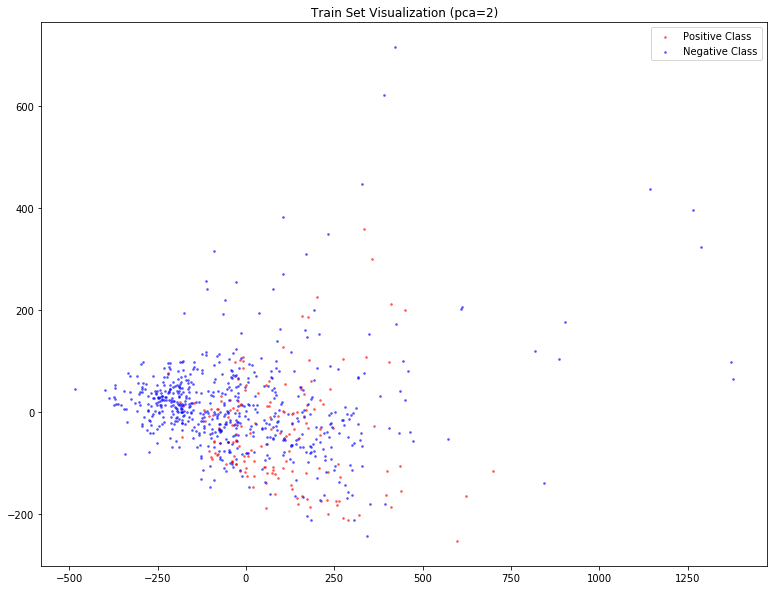

In [21]:
negatives_x = []
negatives_y = []
positives_x = []
positives_y = []
for vec,label in zip(X_train_,y_train):
    x,y = vec[0],vec[1]
    if label==0: # negative
        negatives_x.append(x)
        negatives_y.append(y)
    elif label==1: #postive
        positives_x.append(x)
        positives_y.append(y)
# PLOT
plt.figure(figsize=(13,10))
plt.scatter(positives_x,positives_y,color="red",alpha=0.5,s=3,label="Positive Class")
plt.scatter(negatives_x,negatives_y,color="blue",alpha=0.5,s=3,label="Negative Class")
plt.legend()
plt.title("Train Set Visualization (pca=2)")

Text(0.5,1,'Test Set Visualization (pca=2)')

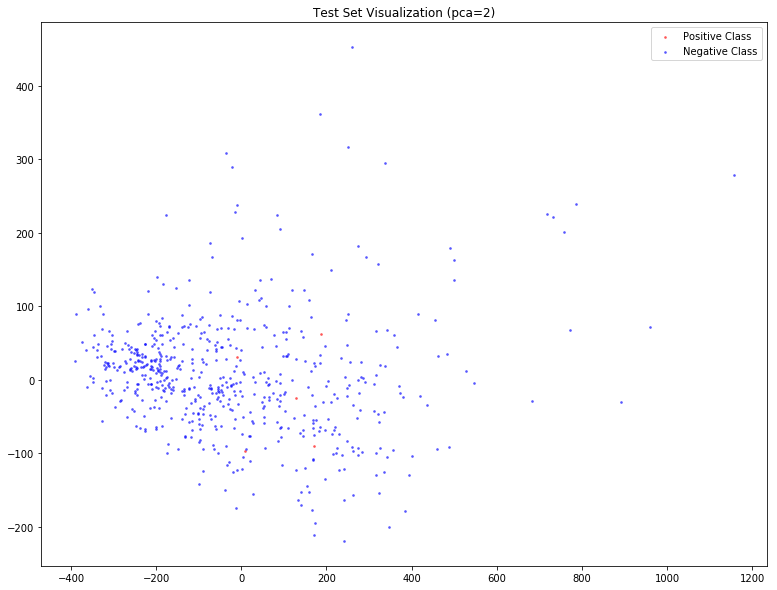

In [22]:
# TEST VISUALIZATION
negatives_x = []
negatives_y = []
positives_x = []
positives_y = []
for vec,label in zip(X_test_,y_test):
    x,y = vec[0],vec[1]
    if label==0: # negative
        negatives_x.append(x)
        negatives_y.append(y)
    elif label==1: #postive
        positives_x.append(x)
        positives_y.append(y)
# PLOT
plt.figure(figsize=(13,10))
plt.scatter(positives_x,positives_y,color="red",alpha=0.5,s=3,label="Positive Class")
plt.scatter(negatives_x,negatives_y,color="blue",alpha=0.5,s=3,label="Negative Class")
plt.legend()
plt.title('Test Set Visualization (pca=2)')

### Hyperparameter Optimization

In [38]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(3)
knn.fit(X_train_,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [39]:
test_pred = knn.predict(X_test_)
train_pred = knn.predict(X_train_)

test_score = roc_auc_score(y_test, test_pred)
train_score = roc_auc_score(y_train, train_pred)
print("Train roc_auc_score: "+str(train_score)+"\n")
print("Test roc_auc_score: "+str(test_score)+"\n")

Train roc_auc_score: 0.921412483912484

Test roc_auc_score: 0.6712837837837837



/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [98]:
parameters = {'n_neighbors':range(2,100),
             'weights':['uniform','distance'],
             'metric':['euclidean','manhattan']}

X_train_ = pca.transform(X_train)
X_test_ = pca.transform(X_test)

knn = KNeighborsClassifier(n_jobs=-1)
clf = GridSearchCV(knn, parameters, cv=10,verbose=1)
clf.fit(X_train_,y_train)

Fitting 10 folds for each of 392 candidates, totalling 3920 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
 

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/li

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'metric': ['euclidean', 'manhattan'], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [99]:
clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

In [100]:
test_pred = clf.predict(X_test_)
train_pred = clf.predict(X_train_)

test_score = roc_auc_score(y_test, test_pred)
train_score = roc_auc_score(y_train, train_pred)
print("Train roc_auc_score: "+str(train_score)+"\n")
print("Test roc_auc_score: "+str(test_score)+"\n")

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


Train roc_auc_score: 0.8779761904761905

Test roc_auc_score: 0.587331081081081



## Oversampling

In [40]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_, y_train)

In [41]:
from collections import Counter
print(sorted(Counter(y_train).items())) # Original data
print(sorted(Counter(y_resampled).items())) # Oversampled data

[(0, 592), (1, 168)]
[(0, 592), (1, 592)]


In [69]:
knn = KNeighborsClassifier(5)
knn.fit(X_resampled,y_resampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [70]:
test_pred = knn.predict(X_test_)
train_pred = knn.predict(X_resampled)

test_score = roc_auc_score(y_test, test_pred)
train_score = roc_auc_score(y_resampled, train_pred)
print("Train roc_auc_score: "+str(train_score)+"\n")
print("Test roc_auc_score: "+str(test_score)+"\n")

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


Train roc_auc_score: 0.9484797297297298

Test roc_auc_score: 0.9290540540540541



# Normalize features

In [71]:
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test_)

In [90]:
knn = KNeighborsClassifier(9)
knn.fit(X_train_scaled,y_resampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [91]:
test_pred = knn.predict(X_test_scaled)
train_pred = knn.predict(X_train_scaled)

test_score = roc_auc_score(y_test, test_pred)
train_score = roc_auc_score(y_resampled, train_pred)
print("Train roc_auc_score: "+str(train_score)+"\n")
print("Test roc_auc_score: "+str(test_score)+"\n")

/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/hacer/Documents/hacervenv/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


Train roc_auc_score: 0.9079391891891893

Test roc_auc_score: 0.6814189189189188



# TEST ALL TASKS

In [29]:
filtersize=64
pca=pca
resize_strategy="strategy1"
parameters = {'n_neighbors':range(2,12)}

In [35]:
from sklearn.model_selection import PredefinedSplit

In [55]:
# PCA + CLASSIFIER
overall_train_score = 0
overall_test_score = 0
for task in list(all_tasks.keys()):
    print(task+"\n")
    X_train,y_train,X_test,y_test=get_data(filtersize)
    
    X_train_ = pca.transform(X_train)
    X_test_ = pca.transform(X_test)

    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X_train_, y_train)
    

    X_train_ = pca.transform(X_train)
    X_test_ = pca.transform(X_test)
    
    #knn = KNeighborsClassifier()
    #clf = GridSearchCV(knn, parameters, cv=10,scoring = 'roc_auc')
    knn = KNeighborsClassifier(5)
    clf = knn

    clf.fit(X_resampled,y_resampled)
    #print(clf.best_estimator_)
    test_pred = clf.predict(X_test_)
    train_pred = clf.predict(X_resampled)

    test_score = roc_auc_score(y_test, test_pred)
    train_score = roc_auc_score(y_resampled, train_pred)
    print("Train roc_auc_score: "+str(train_score)+"\n")
    print("Test roc_auc_score: "+str(test_score)+"\n")
    overall_train_score+=train_score
    overall_test_score+=test_score
print("**Overall train roc_auc_score: "+str(overall_train_score/55.)+"**\n")
print("**Overall test roc_auc_score: "+str(overall_test_score/55.)+"**\n")

c.37.1._c.37.1.6.

Train roc_auc_score: 0.9484797297297298

Test roc_auc_score: 0.9290540540540541

b.40.4._b.40.4.5.

Train roc_auc_score: 0.9937694704049844

Test roc_auc_score: 0.8008540372670807

c.37.1._c.37.1.9.

Train roc_auc_score: 0.9484797297297297

Test roc_auc_score: 0.7164575289575289

c.37.1._c.37.1.5.

Train roc_auc_score: 0.9459459459459458

Test roc_auc_score: 0.9282094594594594

c.37.1._c.37.1.8.

Train roc_auc_score: 0.9484797297297298

Test roc_auc_score: 0.6913415431560592

c.2.1._c.2.1.7.

Train roc_auc_score: 0.9503311258278146

Test roc_auc_score: 0.8820088300220751

a.4.5._a.4.5.28.

Train roc_auc_score: 0.964171974522293

Test roc_auc_score: 0.8347487615003538

c.3.1._c.3.1.4.

Train roc_auc_score: 0.9915384615384615

Test roc_auc_score: 0.6815668202764977

c.37.1._c.37.1.10.

Train roc_auc_score: 0.9484797297297297

Test roc_auc_score: 0.6891891891891891

c.37.1._c.37.1.12.

Train roc_auc_score: 0.9527027027027027

Test roc_auc_score: 0.7623069498069499

b.40

In [63]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, test_pred,target_names=["negative","positive"],output_dict=True)

In [65]:
cr["positive"]

{'f1-score': 0.38095238095238093,
 'precision': 0.2857142857142857,
 'recall': 0.5714285714285714,
 'support': 14}

In [ ]:
print(classification_report(y_test, test_pred,target_names=["positive","negative"]))